In [ ]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
spotify = pd.read_csv("reviews.csv")
spotify

In [ ]:
spotify = spotify.drop("Reply",axis=1)

In [41]:
spotify.head()

,Time_submitted,Review,Rating,Total_thumbsup,Review length
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",positive,2,112
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,positive,1,86
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",positive,0,106
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,negative,1,47
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,negative,1,100


In [42]:
spotify["Review length"]= spotify["Review"].apply(len)
spotify.head()

,Time_submitted,Review,Rating,Total_thumbsup,Review length
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",positive,2,112
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,positive,1,86
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",positive,0,106
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,negative,1,47
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,negative,1,100


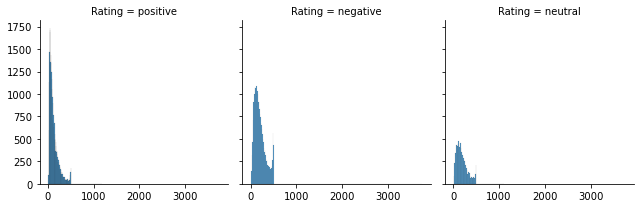

In [43]:
g = sns.FacetGrid(spotify, col="Rating")
g.map_dataframe(sns.histplot, x="Review length")

<AxesSubplot:xlabel='Rating', ylabel='Review length'>

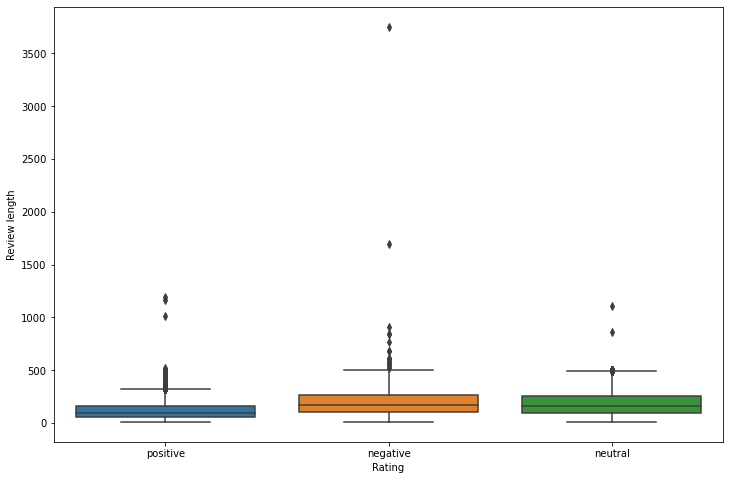

In [44]:
plt.figure(figsize=(12,8))
sns.boxplot(data=spotify,x="Rating",y="Review length")

<AxesSubplot:xlabel='Rating', ylabel='count'>

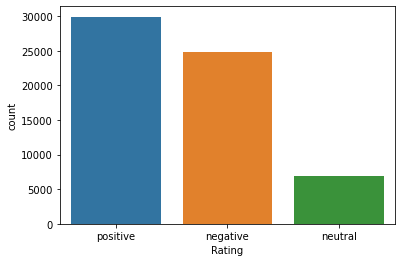

In [45]:
sns.countplot(data=spotify,x="Rating")

In [46]:
spotify.groupby("Rating").mean()

,Total_thumbsup,Review length
Rating,,
negative,9.048605,201.276937
neutral,13.173831,193.854923
positive,5.220897,124.896583


<AxesSubplot:>

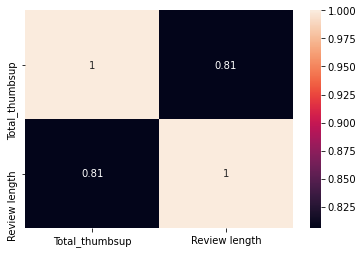

In [47]:
sns.heatmap(spotify.groupby("Rating").mean().corr(),annot=True)

In [48]:
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aabas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
spotify['Review'].head(5).apply(text_process)

0    [Great, music, service, audio, high, quality, ...
1    [Please, ignore, previous, negative, rating, a...
2    [popup, Get, best, Spotify, experience, Androi...
3             [Really, buggy, terrible, use, recently]
4    [Dear, Spotify, get, songs, didnt, put, playli...
Name: Review, dtype: object

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(spotify['Review'])

In [ ]:
review_bow = bow_transformer.transform(spotify['Review'])

In [22]:
print('Shape of Sparse Matrix: ', review_bow.shape)
print('Amount of Non-Zero occurences: ', review_bow.nnz)

Shape of Sparse Matrix:  (61594, 39842)
Amount of Non-Zero occurences:  932954


In [23]:
sparsity = (100.0 * review_bow.nnz / (review_bow.shape[0] * review_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.03801724934411795


In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(max_features=500).fit(review_bow)
review_tfidf = tfidf_transformer.transform(review_bow)

In [25]:
spotify["Rating"].replace(1, value="negative",inplace=True)
spotify["Rating"].replace(2, value="negative",inplace=True)
spotify["Rating"].replace(3, value="neutral",inplace=True)
spotify["Rating"].replace(4, value="positive",inplace=True)
spotify["Rating"].replace(5, value="positive",inplace=True)
spotify.head()

,Time_submitted,Review,Rating,Total_thumbsup,Review length
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",positive,2,112
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,positive,1,86
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",positive,0,106
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,negative,1,47
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,negative,1,100


In [27]:
review_tfidf.shape

(61594, 39842)

In [28]:
X=review_tfidf
y=spotify["Rating"].apply()

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2 , random_state=101)

In [31]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.fit_transform(y_test)
from xgboost import XGBClassifier
xgb=XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [32]:
prediction = xgb.predict(X_test)
from sklearn.metrics import classification_report
print (classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      4967
           1       0.43      0.06      0.10      1366
           2       0.82      0.87      0.85      5986

    accuracy                           0.77     12319
   macro avg       0.66      0.59      0.58     12319
weighted avg       0.74      0.77      0.74     12319

